<a href="https://colab.research.google.com/github/oleksandr-alvarez/project/blob/master/macroeconomtrics_project_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# this code is written based on the idea and initial code written by my group mate the the University of Tartu Pedro Marco Melo Silva. 
# https://github.com/marcusaureliusantonius

from datetime import date
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from prophet import Prophet
from google.colab import drive

In [2]:
# Since on my machine I could not install the prophet package, I found a workaround and wrote a code in Collab.
# To access the files on my Google Drive, we have to drive.mount

drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [5]:
# Read the data into the df

df = pd.read_excel("/content/gdrive/My Drive/la uni/weekly_crude_2.xls")

#excel_brent = excel_brent.iloc[2:]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575 entries, 0 to 574
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  575 non-null    datetime64[ns]
 1   y                 575 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.1 KB


In [6]:
# df.observation_date = pd.to_datetime(df.observation_date)

In [7]:
# Rename the column with a date since prophet require one column to have a title "ds"

df = df.rename(columns = {'observation_date':'ds'})

In [8]:
# df.set_index('ds')

,y
ds,
2012-01-06,111.96
2012-01-13,109.88
2012-01-20,108.50
2012-01-27,110.50
2012-02-03,112.56
...,...
2022-12-09,76.37
2022-12-16,80.20
2022-12-23,82.45


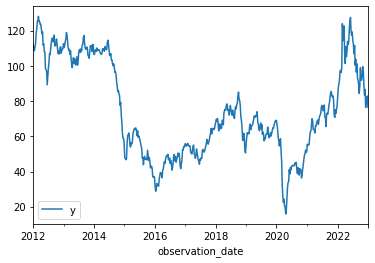

In [ ]:
# plot the data to see how it looks like
# df.plot(x = 'observation_date')

In [9]:
# Split the data into the training and testing sets

df_train = df[:round(len(df)*0.95)]
df_test = df[round(len(df)*0.95):]

In [24]:
# df_train.tail()

In [25]:
# df_test.head()

In [10]:
# Specify the holiday periods which will later be included into the prophet model
# These will be treated as one-off events that won't be included into the seasonal trend
# This holiday set includes the shocks occured in 2020 - 2022
# 2020 - 2021: Covid pandemic and subsequent measures put in place to curbe the spread of the disease 
# Late 2021 - 2022: Russian invasion into Ukraine; russian oil price manupulation on the russian government part

holds = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-15', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
    {'holiday': 'lockdown_4', 'ds': '2021-12-03', 'lower_window': 0, 'ds_upper': '2022-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    holds[t_col] = pd.to_datetime(holds[t_col])
holds['upper_window'] = (holds['ds_upper'] - holds['ds']).dt.days
holds

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-15,0,2020-06-06,83
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13
4,lockdown_4,2021-12-03,0,2022-06-10,189


In [11]:
# Fit the first Prophet model (without holidays) on the training set

m1 = Prophet(interval_width = 0.95, weekly_seasonality=True)
m1.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/8mgxhpdf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/npne4bfz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67783', 'data', 'file=/tmp/tmpcwfz3yak/8mgxhpdf.json', 'init=/tmp/tmpcwfz3yak/npne4bfz.json', 'output', 'file=/tmp/tmpcwfz3yak/prophet_modelxv0z8gh2/prophet_model-20230125142910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [12]:
# Make the dataframe of the future predictions outside of the training set.
# Since from the data was collected as weekly data (eniding on Friday), we specify the frequency

future1 = m1.make_future_dataframe(periods=29, freq = "W-FRI", include_history = True)


forecast1 = m1.predict(future1)
df_forecast1 = forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

<ipython-input-80-369f4cfe476d>:11: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



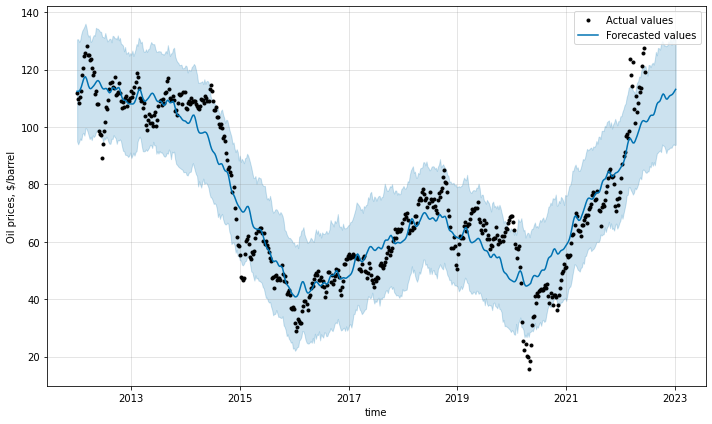

In [80]:
# Plot the forecasted and the actual oil price values and save the graph
# use plot_plotly to obtain the interactive graph

from prophet.plot import plot_plotly, plot_components_plotly

# prophet_plot_1 = plot_plotly(m1, df_forecast1)

# !pip install kaleido

# prophet_plot_1.write_image("fig1.png")

prophet_plot_1 = m1.plot(forecast1);


ax = plt.subplot()

ax.set(xlabel='time', ylabel='Oil prices, $/barrel')
ax.legend(['Actual values', 'Forecasted values'])
prophet_plot_1
prophet_plot_1.savefig('/content/gdrive/My Drive/la uni/Proph_forecast_v_actual_full.png', dpi = 1080, transparent = True)

plt.show()

In [14]:
# df_test.tail()
# forecast1.tail()
# df_1 = pd.DataFrame(pd.concat([df.y, forecast1.yhat], axis = 1))

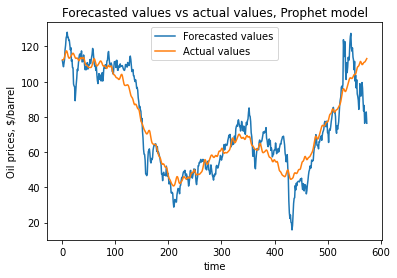

In [29]:
# Plot another grapgh to clearly see the difference between the forecasted and the actual values. Save the graph

# fig, ax = plt.subplots()
# ax.plot(df_1)

# ax.set(xlabel='time', ylabel='Oil prices, $/barrel',
#        title='Forecasted values vs actual values, Prophet model')
# ax.legend(['Forecasted values', 'Actual values'])

# fig.savefig('Proph_forecast_v_actual_full.png', dpi = 1080, transparent = True)
# plt.show()

In [16]:
# Perform cross validation and calculate different metrics including the rmse which later could be used to compare the models

from prophet.diagnostics import cross_validation
df_cv = cross_validation(m1,period='7 days', horizon = '203 days')

INFO:prophet:Making 430 forecasts with cutoffs between 2013-09-06 00:00:00 and 2021-11-26 00:00:00


  0%|          | 0/430 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/ab5zfn2j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/etati01u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77382', 'data', 'file=/tmp/tmpcwfz3yak/ab5zfn2j.json', 'init=/tmp/tmpcwfz3yak/etati01u.json', 'output', 'file=/tmp/tmpcwfz3yak/prophet_modelribtberz/prophet_model-20230125143035.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:30:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:30:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/4hbok373.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/wl5n5513.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [17]:
# Calculate the performance metrics

from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,21 days,186.208327,13.645817,10.683749,0.198310,0.145397,0.192196,0.674820
1,28 days,210.411548,14.505570,11.431104,0.211825,0.153899,0.205968,0.648998
2,35 days,228.858353,15.128065,11.954423,0.221490,0.162382,0.215940,0.633520
3,42 days,246.122629,15.688296,12.415623,0.230095,0.168665,0.224950,0.614996
4,49 days,266.243811,16.316979,12.927630,0.239548,0.180783,0.234984,0.599278
5,56 days,289.300336,17.008831,13.498599,0.249916,0.184660,0.246152,0.577706
6,63 days,312.746941,17.684653,14.067880,0.260192,0.201371,0.257372,0.561267
7,70 days,335.227779,18.309227,14.606165,0.269871,0.216511,0.268078,0.538974
8,77 days,357.489328,18.907388,15.137684,0.279396,0.225237,0.278743,0.522454
9,84 days,380.883897,19.516247,15.693945,0.289340,0.233168,0.290034,0.502646


In [18]:
# Calculate mean rmse 

df_p['rmse'].mean()

21.8236083297466

/usr/local/lib/python3.8/dist-packages/prophet/plot.py:544: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/usr/local/lib/python3.8/dist-packages/prophet/plot.py:545: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



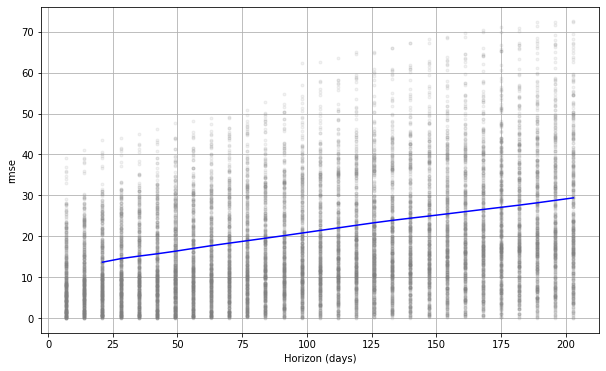

In [19]:
# Plot the cross validation metric = rmse

from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [ ]:
#download data
# df_forecast1.to_csv('/content/gdrive/My Drive/la uni/forecast_prophet.csv')
# new_brent.to_csv('/content/gdrive/My Drive/la uni/BRENTPRICESTREATED.csv')
# df_p.to_csv('/content/gdrive/My Drive/la uni/performance_of_forecast.csv')

In [68]:
# Now I am going to fit another Prophet model.
# This time I will include the holiday periods (specified earlier) into the model

m2 = Prophet(interval_width = 0.95, weekly_seasonality=True, holidays = holds)
m2.fit(df_train)
future2 = m2.make_future_dataframe(periods=29, freq = "W-FRI", include_history = True)


forecast2 = m2.predict(future2)
df_forecast2 = forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/b6lfkl1l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/wuu6acxf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77673', 'data', 'file=/tmp/tmpcwfz3yak/b6lfkl1l.json', 'init=/tmp/tmpcwfz3yak/wuu6acxf.json', 'output', 'file=/tmp/tmpcwfz3yak/prophet_model9kby94ea/prophet_model-20230125155944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:59:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:59:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<ipython-input-79-9e4074b01142>:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



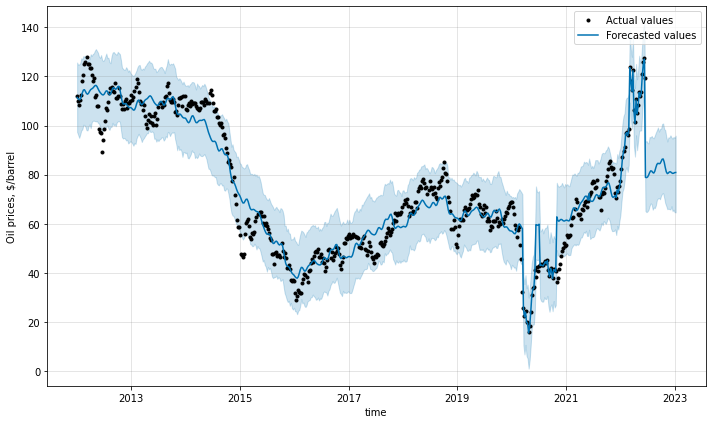

In [79]:
from prophet.plot import plot_plotly, plot_components_plotly

# prophet_plot_2 = plot_plotly(m2, df_forecast2)

prophet_plot_2 = m2.plot(forecast2);

ax = plt.subplot()

ax.set(xlabel='time', ylabel='Oil prices, $/barrel')
ax.legend(['Actual values', 'Forecasted values'])
prophet_plot_2.savefig('/content/gdrive/My Drive/la uni/Proph_holds_forecast_v_actual_full.png', dpi = 1080, transparent = True)

plt.show()

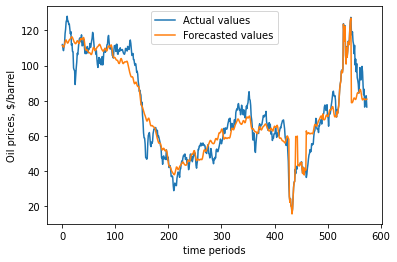

In [83]:
df_2 = pd.DataFrame(pd.concat([df.y, forecast2.yhat], axis = 1))
fig, ax = plt.subplots()
ax.plot(df_2)

ax.set(xlabel='time periods', ylabel='Oil prices, $/barrel')
ax.legend(['Actual values', 'Forecasted values'])

fig.savefig('/content/gdrive/My Drive/la uni/Proph_holds_1_forecast_v_actual_full.png', dpi = 1080, transparent = True)
plt.show()

In [23]:
from prophet.diagnostics import cross_validation
df_cv_1 = cross_validation(m2,period='7 days', horizon = '203 days')

INFO:prophet:Making 430 forecasts with cutoffs between 2013-09-06 00:00:00 and 2021-11-26 00:00:00


  0%|          | 0/430 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/70r2yvb8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/9qlkdwix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44961', 'data', 'file=/tmp/tmpcwfz3yak/70r2yvb8.json', 'init=/tmp/tmpcwfz3yak/9qlkdwix.json', 'output', 'file=/tmp/tmpcwfz3yak/prophet_modelhdn75_ut/prophet_model-20230125143732.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:37:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/h8vlvuxm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/5zrmuxmq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [26]:
from prophet.diagnostics import performance_metrics
df_p_1 = performance_metrics(df_cv_1)
df_p_1

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,21 days,163.142366,12.772720,10.208267,0.200040,0.147188,0.181669,0.696391
1,28 days,182.231062,13.499299,10.874428,0.211385,0.156295,0.193629,0.664956
2,35 days,197.180458,14.042096,11.345053,0.219671,0.163215,0.202390,0.644266
3,42 days,211.287431,14.535729,11.757014,0.227106,0.170765,0.210297,0.623496
4,49 days,227.655032,15.088242,12.204140,0.235163,0.178930,0.218939,0.602967
5,56 days,246.424443,15.697912,12.699770,0.244005,0.186391,0.228491,0.576664
6,63 days,265.633605,16.298270,13.196715,0.252842,0.196270,0.238105,0.549399
7,70 days,284.109812,16.855557,13.669424,0.261272,0.208512,0.247333,0.530313
8,77 days,302.471410,17.391705,14.137158,0.269615,0.217504,0.256559,0.511307
9,84 days,321.835990,17.939788,14.626576,0.278385,0.226169,0.266351,0.492061


In [88]:
# Calculate the rmse metric. As we can see this model performs slightly better than the previous one.

df_p_1['rmse'].mean()

19.993017873254125

In [71]:
# In the first place I did not include the shock that ocurred in 2014 - 2015, when the oil price dropped significantly
# This happened due to the multiple factors, including the boosting of the US oil extracting
# I will include this shock now and fit the new Prophet model

holds1 = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2014-10-03', 'lower_window': 0, 'ds_upper': '2015-01-30'},
    {'holiday': 'lockdown_1', 'ds': '2020-03-15', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
    {'holiday': 'lockdown_4', 'ds': '2021-12-03', 'lower_window': 0, 'ds_upper': '2022-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    holds1[t_col] = pd.to_datetime(holds1[t_col])
holds1['upper_window'] = (holds1['ds_upper'] - holds1['ds']).dt.days
holds1

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2014-10-03,0,2015-01-30,119
1,lockdown_1,2020-03-15,0,2020-06-06,83
2,lockdown_2,2020-07-09,0,2020-10-27,110
3,lockdown_3,2021-02-13,0,2021-02-17,4
4,lockdown_4,2021-05-28,0,2021-06-10,13
5,lockdown_4,2021-12-03,0,2022-06-10,189


In [72]:
m3 = Prophet(interval_width = 0.95, weekly_seasonality=True, holidays = holds1)
m3.fit(df_train)
future3 = m3.make_future_dataframe(periods=29, freq = "W-FRI", include_history = True)


forecast3 = m3.predict(future3)
df_forecast3 = forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/zhh5lgyg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/del5r6i7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28302', 'data', 'file=/tmp/tmpcwfz3yak/zhh5lgyg.json', 'init=/tmp/tmpcwfz3yak/del5r6i7.json', 'output', 'file=/tmp/tmpcwfz3yak/prophet_modelm9xro6l3/prophet_model-20230125160112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:01:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:01:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<ipython-input-84-535e0eeadf27>:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



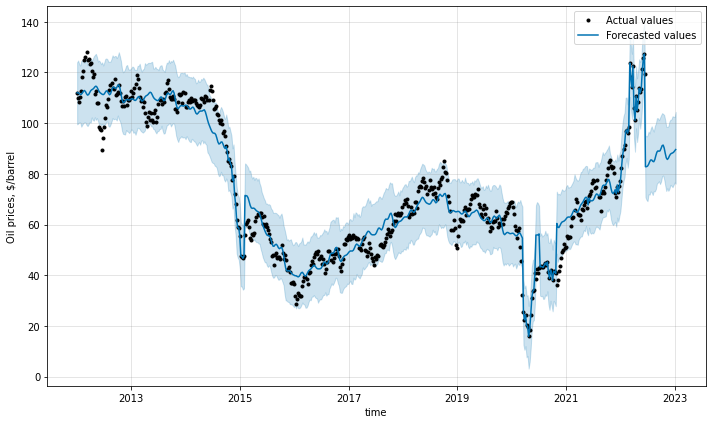

In [84]:
from prophet.plot import plot_plotly, plot_components_plotly

# prophet_plot_2 = plot_plotly(m2, df_forecast2)

prophet_plot_3 = m3.plot(forecast3);

ax = plt.subplot()

ax.set(xlabel='time', ylabel='Oil prices, $/barrel')
ax.legend(['Actual values', 'Forecasted values'])
prophet_plot_3.savefig('/content/gdrive/My Drive/la uni/Proph_holds1_forecast_v_actual_full.png', dpi = 1080, transparent = True)

plt.show()

In [74]:
from prophet.diagnostics import cross_validation
df_cv_2 = cross_validation(m3,period='7 days', horizon = '203 days')

from prophet.diagnostics import performance_metrics
df_p_2 = performance_metrics(df_cv_2)
df_p_2


INFO:prophet:Making 430 forecasts with cutoffs between 2013-09-06 00:00:00 and 2021-11-26 00:00:00


  0%|          | 0/430 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/acvix5y0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/ar5qkchp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54458', 'data', 'file=/tmp/tmpcwfz3yak/acvix5y0.json', 'init=/tmp/tmpcwfz3yak/ar5qkchp.json', 'output', 'file=/tmp/tmpcwfz3yak/prophet_modele2xqigo3/prophet_model-20230125160240.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:02:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:03:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/6u4v19eb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwfz3yak/ymitwbue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,21 days,199.630334,14.129060,10.450097,0.202992,0.134151,0.179902,0.658380
1,28 days,218.008969,14.765127,11.087917,0.213897,0.140014,0.191308,0.622935
2,35 days,233.488377,15.280326,11.564035,0.222220,0.149422,0.199966,0.596712
3,42 days,248.652804,15.768729,11.992326,0.229861,0.158024,0.207892,0.573857
4,49 days,265.598494,16.297193,12.454259,0.238144,0.163364,0.216532,0.552686
5,56 days,283.973215,16.851505,12.953353,0.247086,0.170041,0.225980,0.529350
6,63 days,302.210106,17.384191,13.441710,0.255813,0.177831,0.235332,0.502245
7,70 days,319.580603,17.876817,13.892992,0.263835,0.191070,0.244079,0.481315
8,77 days,336.468014,18.343064,14.322404,0.271378,0.199718,0.252483,0.458380
9,84 days,353.538423,18.802617,14.762819,0.279093,0.206370,0.261229,0.439455


In [89]:
# Calculate the rmse

df_p_2['rmse'].mean()

20.640795234626754